# Import Libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report,roc_curve, auc, recall_score

# Load Dataset

In [2]:
# Load the dataset
df = pd.read_csv('raw_data.csv')

# Descriptive Statistics

In [3]:
# General information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


Pengamatan\:
1. Data terdiri dari 381109 baris
2. Tidak terdapat null values atau nilai kosong di setiap kolom
3. Sepertinya tidak ada issue yang mencolok pada tipe data untuk setiap kolom (sudah sesuai)

### Duplicated data

In [4]:
# See the duplicated record in dataset
df.duplicated().sum()

0

Tidak terdapat data yang duplikat

## Cuplikan Data

In [5]:
# 5 random sample of the dataset
df.sample(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
110108,110109,Female,33,1,28.0,1,1-2 Year,No,26292.0,26.0,43,0
45312,45313,Female,30,1,3.0,1,< 1 Year,No,33511.0,152.0,157,0
162829,162830,Male,45,1,46.0,0,1-2 Year,Yes,19718.0,157.0,181,1
233449,233450,Male,30,1,28.0,0,< 1 Year,Yes,70214.0,124.0,81,0
261,262,Female,22,1,12.0,1,< 1 Year,No,29823.0,152.0,128,0


Pengamatan:
* Sepertinya tidak ada anomali pada setiap entri kolom sudah sesuai

## Statistical Summary

In [6]:
# Grouping columns with spesific datatype
nums = [feature for feature in df.columns if df[feature].dtypes != 'O']
cats = [feature for feature in df.columns if df[feature].dtypes == 'O']

In [7]:
# Statistical summary of Numeric feature
df[nums].describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


Beberapa pengamatan:
1. Pada kolom `Age`, nilai mean dan mediannya tidak terlalu jauh mengindikasikan kolom tersebut memiliki distribusi normal
2. Begitu pula pada kolom `Annual Premium`, nilai mean dan mediannya tidak terlalu jauh, namun pada nilai `max` nya sangat jauh sekali dibanding nilai pada data 75%, nampaknya terdapat `outliers` yang cukup jauh. Akan kita lakukan handling outliers nanti pada tahap Data Processing.
3. Kolom `Driving License`dan `Previously Insured` adalah kolom dengan nilai binary (1 dan 0)
4. Untuk kolom `Region Code` meskipun sebuah kolom numerik tetapi kolom tersebut memuat informasi mengenai kode daerah pelanggan. Begitu pula dengan kolom `Policy Sales Channel` adalah sebuah kode unik mengenai cara perusahaan menjangkau / menghubungi pelanggan.

In [8]:
# Statistical summary of Categorical feature
df[cats].describe()

,Gender,Vehicle_Age,Vehicle_Damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


Beberapa pengamatan:
1. Data di dominasi (proporsi lebih dari 50% dari jumlah baris data) oleh jenis kelamin laki-laki (`Gender`) dan 1-2 Year (`Vehicle Age`)
2. Kolom `Vehicle Damage` memiliki proporsi yang relatif sama diantara 2 nilai nya.

## Value Counting
Kita dapat memastikan pengamatan mengenai kolom-kolom categorical di atas dengan value counting

In [9]:
# Count every value from Categorical feature
for col in cats:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

Value count kolom Gender:
Male      206089
Female    175020
Name: Gender, dtype: int64

Value count kolom Vehicle_Age:
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

Value count kolom Vehicle_Damage:
Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64



## Univariate Analysis
Setelah melakukan analisis sederhana tentang statistik deskriptif, sekarang kita fokus pada satu-persatu kolom dengan *Univariate Analysis*

### Distribusi Target feature

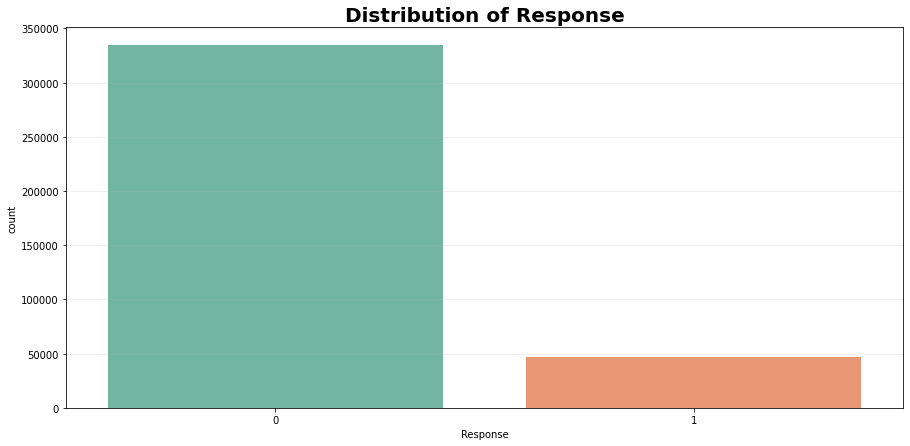

In [10]:
plt.figure(figsize=(15,7))
sns.countplot(x='Response', data=df, palette=sns.color_palette('Set2'))
plt.grid(axis='y', alpha=0.25)
plt.title('Distribution of Response', fontsize=20, weight='bold')
plt.savefig('images/distribution_of_response.png')
plt.show()

Pada kolom `Response` atau kolom yang berperan sebagai kolom target, berisi angka 0 dan 1. `Angka 0` menandakan pelanggan tersebut tidak tertarik dan `angka 1` menandakan pelanggan tertarik pada penawaran asuransi kendaraan yang perusahaan tawarkan. Terlihat perbandingannya cukup timpang, lebih banyak orang yang tidak tertarik. Hal ini bisa disebut juga sebagai `Imbalance Dataset`. Hal seperti ini bisa mempengaruhi performa pada saat modeling. Bila diperlukan, kita bisa melakukan teknik oversampling atau under sampling pada saat modeling nanti agar bisa mendapatkan performa model yang optimal.

### Box Plots

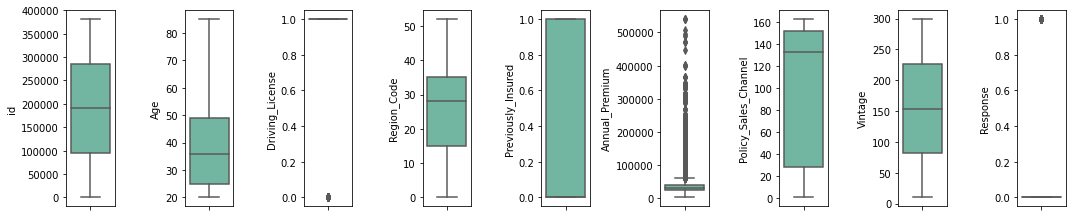

In [11]:
features = nums
plt.figure(figsize=(15,6))
for i in range(0, len(features)):
    plt.subplot(2, len(features), i+1)
    sns.boxplot(y=df[features[i]], palette=sns.color_palette('Set2'))
    plt.tight_layout()
    plt.savefig('images/box_plot.png')

Untuk boxplot, hal paling penting yang harus kita perhatikan adalah keberadaan outlier.
* Outlier terlihat utamanya pada kolom `Annual Premium`
* Dari boxplotnya juga tampak mana kolom yang distribusinya terlihat agak *skewed*: `Age` dan `Policy Sales Channel`

### Dist Plots

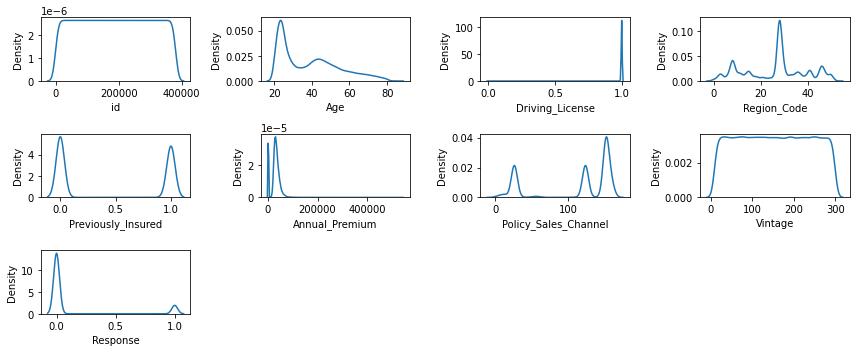

In [14]:
features = nums
plt.figure(figsize=(12, 5))
for i in range(0, len(nums)):
    plt.subplot(3, len(nums)-5, i+1)
    sns.kdeplot(x=df[features[i]], palette=sns.color_palette('Set2'))
    plt.xlabel(features[i])
    plt.tight_layout()
    plt.savefig('images/dist_plot.png')

Untuk distribution plot, hal utama yang perlu diperhatikan adalah bentuk distribusi:
* Kolom `Age` ternyata cenderung sedikit mengarah ke positively skewed.
* Seperti dugaan kita ketika melihat boxplot di atas, kolom `Annual Premium` lumayan *skewed*, hal tersebut dikarenakan keberadaan nilai outliers atau nilai yang terlalu jauh dari semestinya.
* Kolom `Vintage` memiliki distribusi normal.
* Untuk kolom `Region` dan `Policy Sales Channel` tidak perlu terlalu diperhatikan, karena nilai numerik dalam kolom tersebut hanya sebagai kode unik atau sebuah label.
* Kolom `Driving License` dan `Previously Insured` sejatinya adalah biner, sehingga tidak perlu terlalu diperhatikan bentuk distribusinya

### Count Plot (categorical)

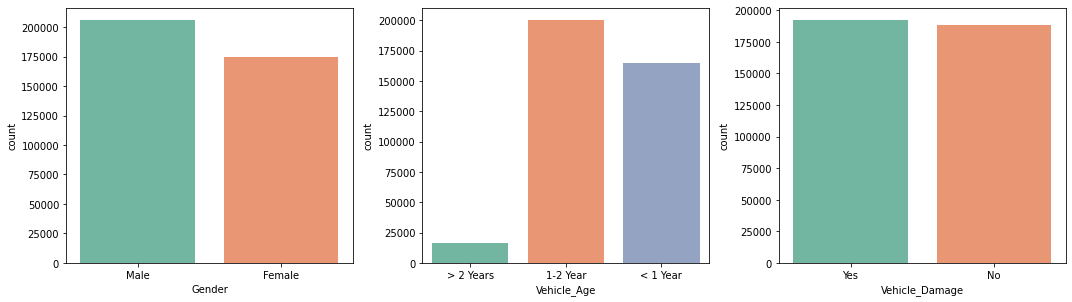

In [15]:
plt.figure(figsize=(15, 8))
for i in range(0, len(cats)):
    plt.subplot(2, 3, i+1)
    sns.countplot(x = df[cats[i]], palette=sns.color_palette('Set2'))
    plt.tight_layout()

Terakhir kita lihat count plot untuk setiap data. Seperti pengamatan kita sebelumnya, distribusi `Gender` dan `Vehicle Age` didominasi 1-2 value.

## Bivariate Analysis

Setelah menilik setiap kolom secara individual, sekarang kita akan melihat hubungan antar kolom. Mengetahui hubungan antar kolom dapat membantu kita memilih fitur-fitur yang paling penting dan mengesampingkan *feature* yang redundan.

### Correlation between Independent and Dependent Feature

### Response by Gender

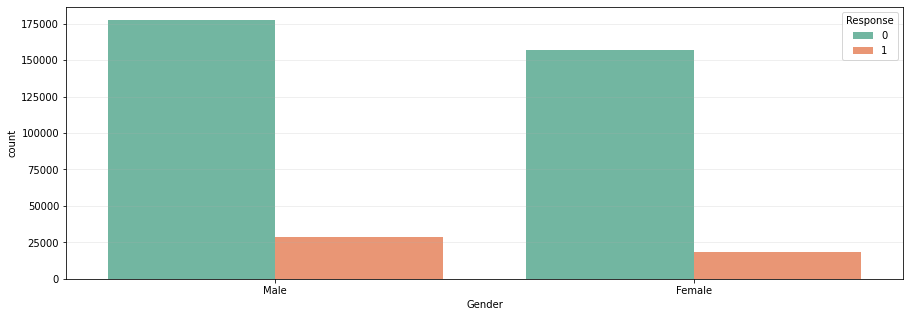

In [16]:
plt.figure(figsize=(15, 5))
sns.countplot(x='Gender', hue='Response', data=df, palette=sns.color_palette('Set2'))
plt.grid(axis='y', alpha=0.25)
plt.show()

Either pelanggan yang tertarik maupun yang tidak tertarik didominasi oleh jenis kelamin laki-laki

### Response by Age

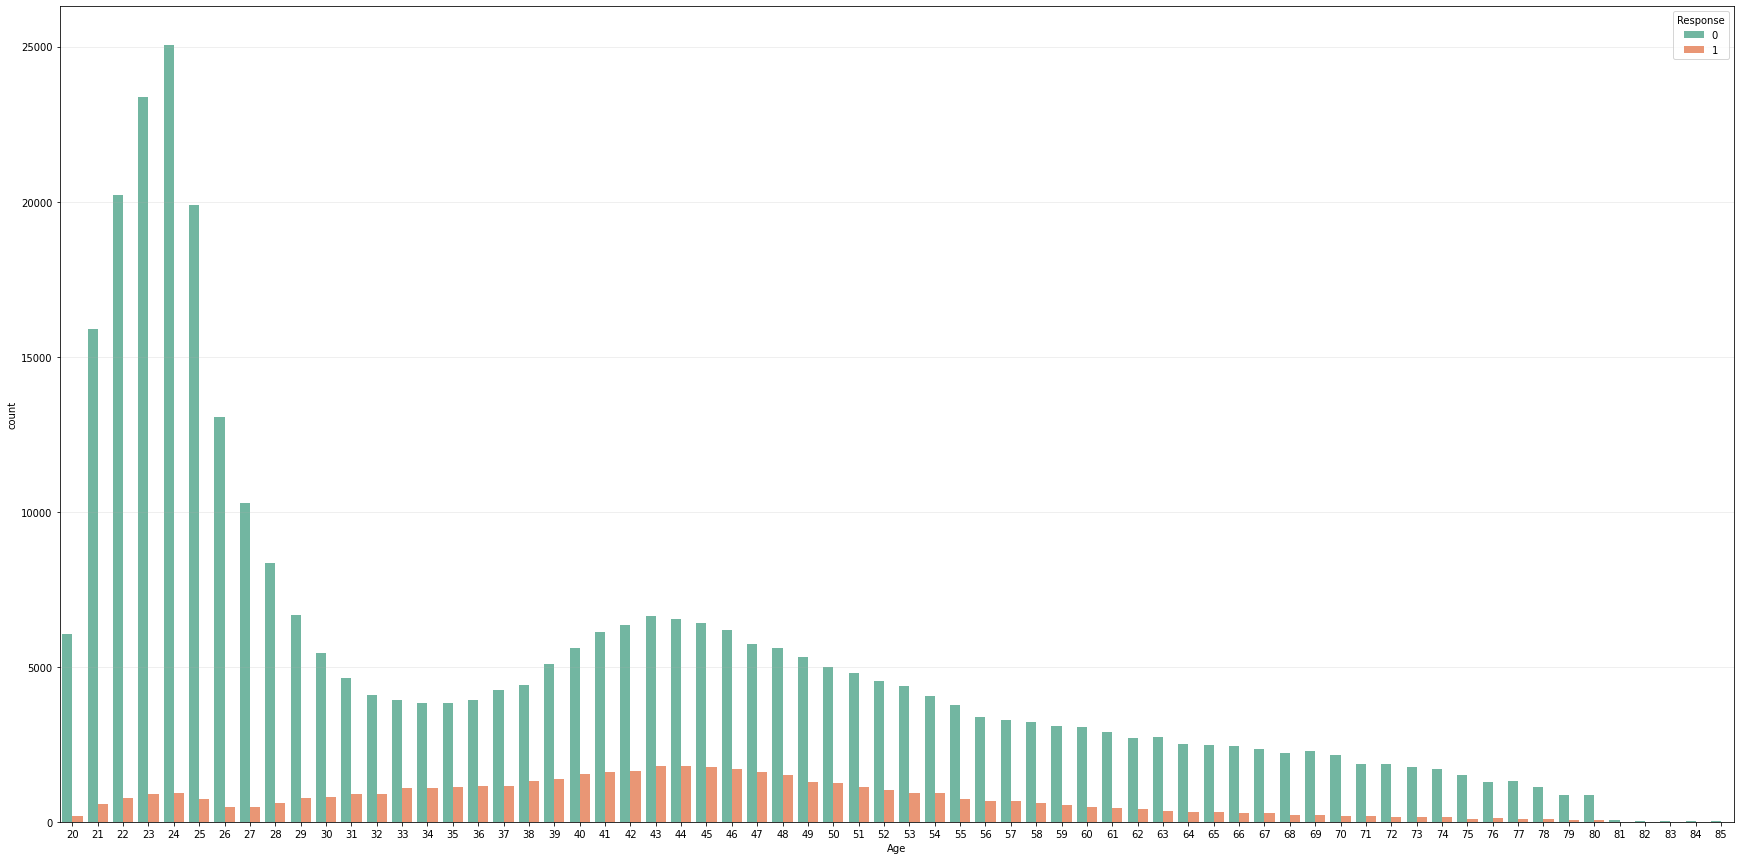

In [17]:
plt.figure(figsize=(30,15))
sns.countplot(x='Age', hue='Response', data=df, palette=sns.color_palette('Set2'))
plt.grid(axis='y', alpha=0.25)
plt.show()

Pelanggan yang tidak tertarik sangat didominasi oleh pelanggan yang masih muda dengan rentang usia antara 20 - 30 tahun.

### Response by Driving License

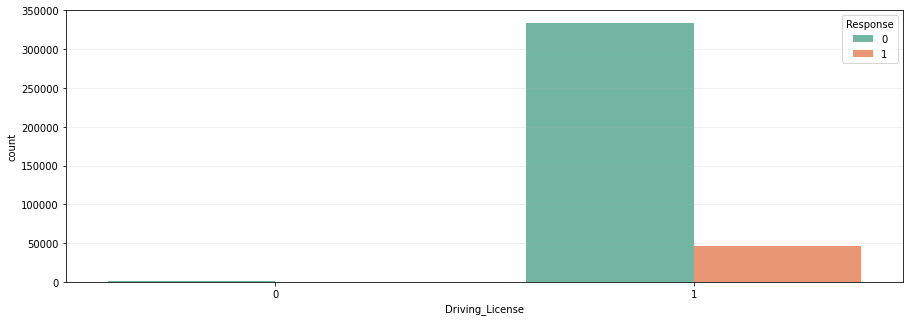

In [18]:
plt.figure(figsize=(15, 5))
sns.countplot(x='Driving_License', hue='Response', data=df, palette=sns.color_palette('Set2'))
plt.grid(axis='y', alpha=0.25)
plt.show()

Karena perbandingan jumlah pelanggan yang memiliki dan yang tidak memiliki surat izin mengemudi ini sangat timpang jauh hampir 99:1. Kemungkinan kolom ini kurang berpengaruh terhadap response.

### Response by Region Code

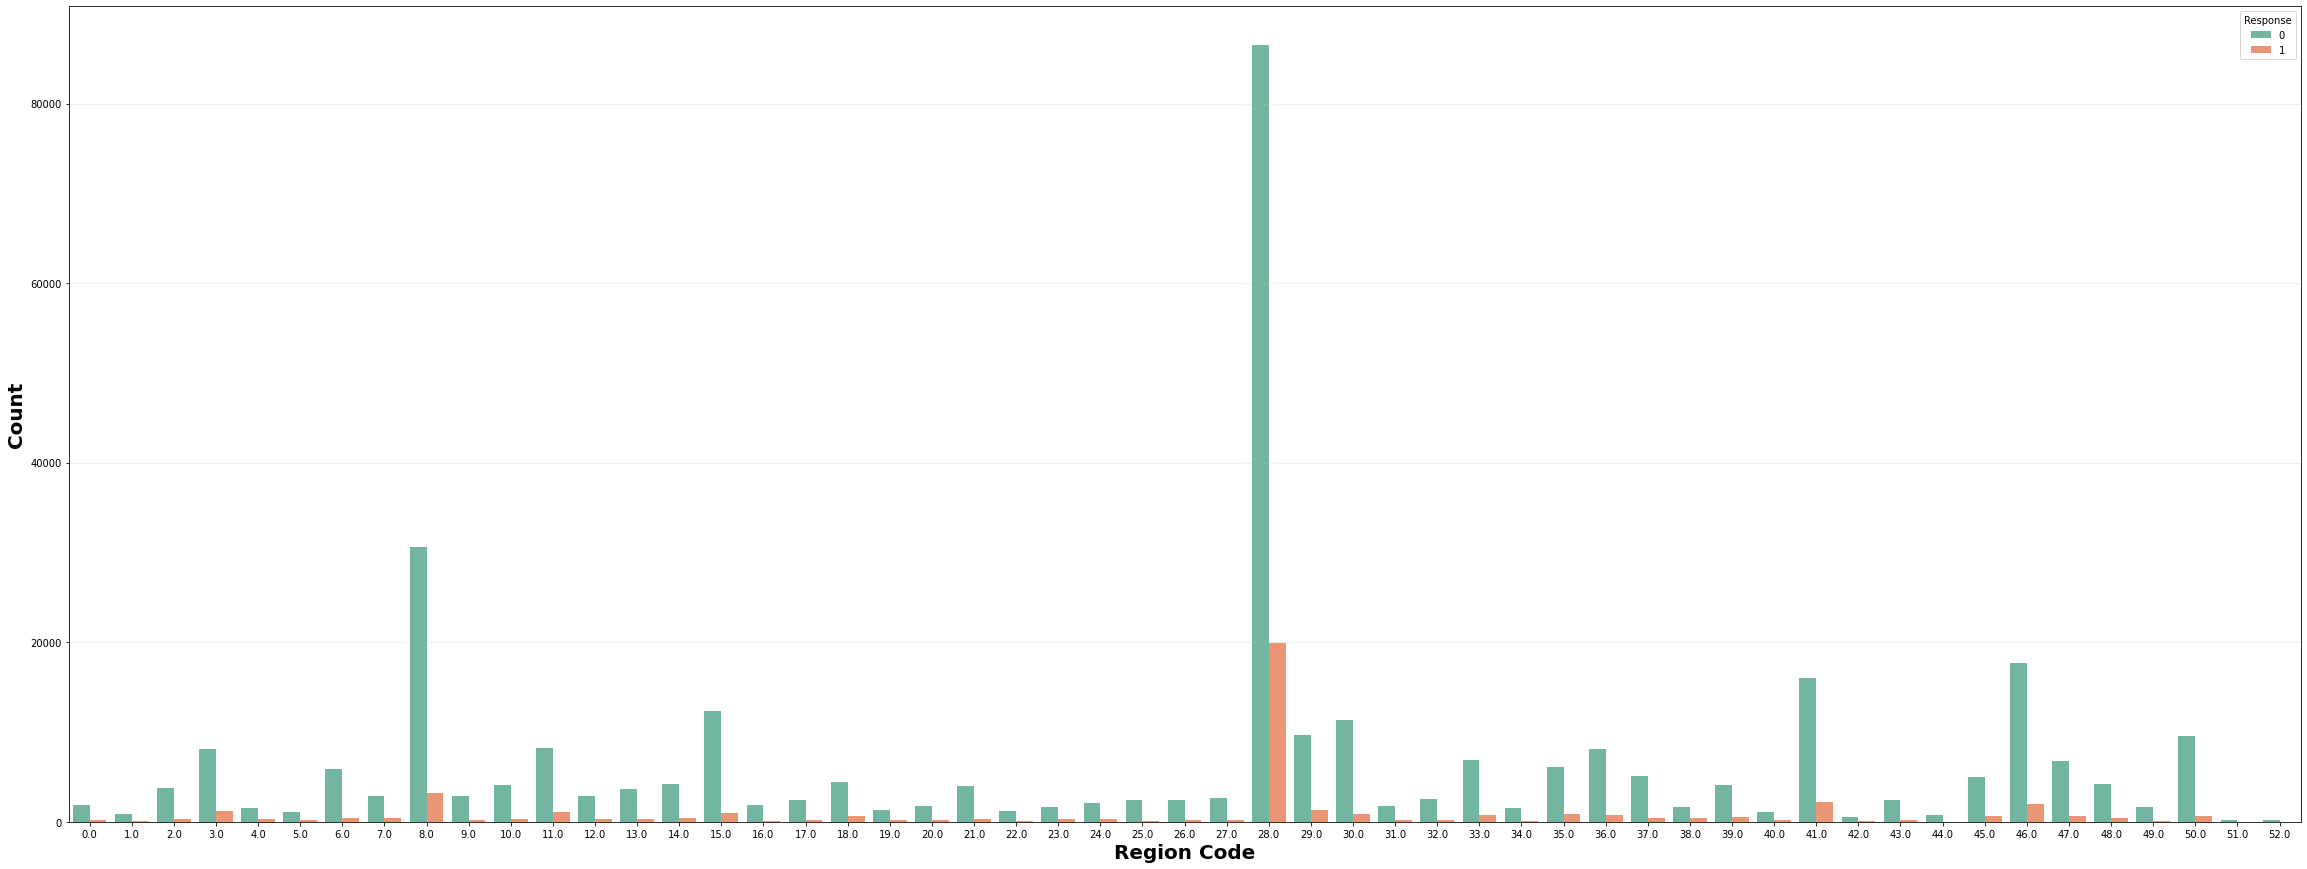

In [19]:
plt.figure(figsize=(40,15))
sns.countplot(x='Region_Code', hue='Response', data=df, palette=sns.color_palette('Set2'))
plt.grid(axis='y', alpha=0.25)
plt.xlabel('Region Code',fontsize=20, weight='bold')
plt.ylabel('Count',fontsize=20, weight='bold')
plt.show()

Kode region 28 memiliki grafik yang tinggi, baik yang tertarik maupun yang tidak tertarik, mengindikasikan dataset didominasi oleh pelanggan yang berasal dari daerah dengan kode region 28.

### Response by Previously Insured

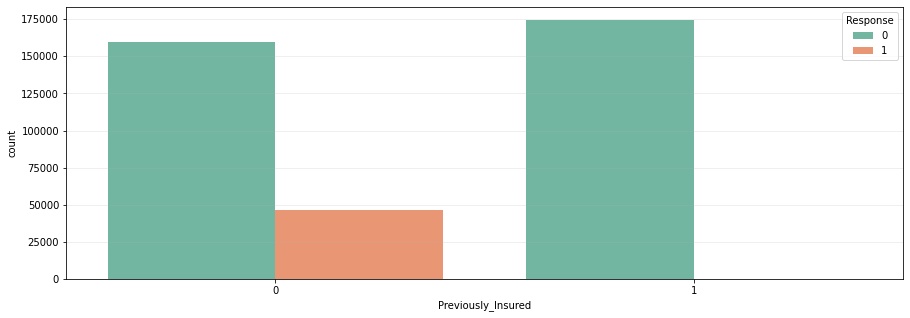

In [20]:
plt.figure(figsize=(15, 5))
sns.countplot(x='Previously_Insured', hue='Response', data=df, palette=sns.color_palette('Set2'))
plt.grid(axis='y', alpha=0.25)
plt.show()

Dari visualisasi diatas, pelanggan yang sebelumnya memiliki asuransi kendaraan memang sedikit bahkan hampir tidak ada yang tertarik.

### Response by Vehicle Age

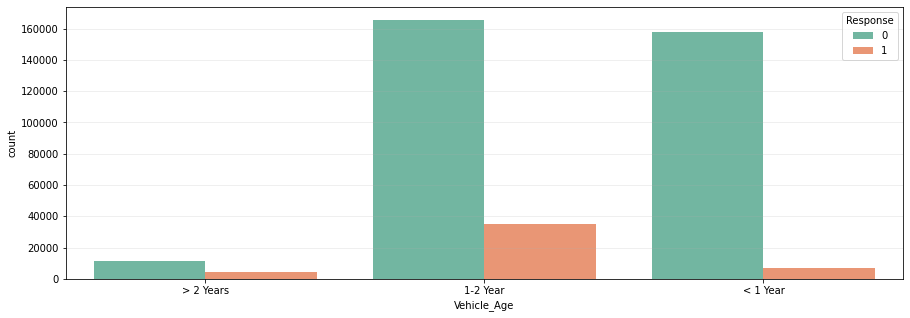

In [21]:
plt.figure(figsize=(15, 5))
sns.countplot(x='Vehicle_Age', hue='Response', data=df, palette=sns.color_palette('Set2'))
plt.grid(axis='y', alpha=0.25)
plt.show()

Pengamatan:<br>
1. Baik pelanggan yang tertarik maupun yang tidak tertarik, keduanya didominasi oleh pelanggan yang memiliki kendaraan dengan usia kendaraannya 1 - 2 tahun.
2. Hal menarik terlihat pada pelanggan yang memiliki kendaraan dengan usia kendaraannya kurang dari 1 tahun, perbandingannya sangat timpang sekali, mereka cenderung tidak tertarik terhadap penawaran asuransi kendaraan yang kita tawarkan.

### Response by Vehicle Damage

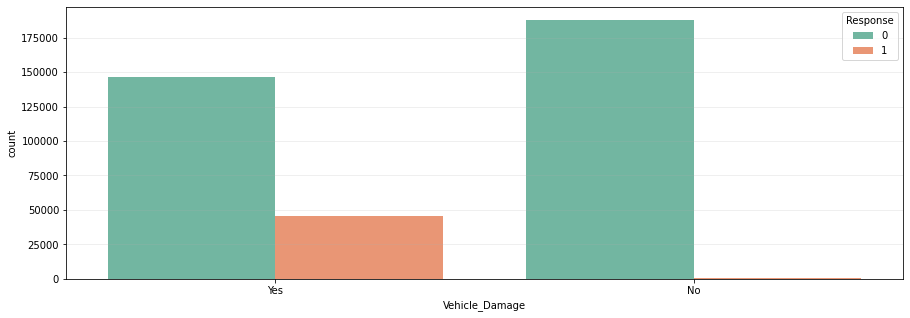

In [22]:
plt.figure(figsize=(15, 5))
sns.countplot(x='Vehicle_Damage', hue='Response', data=df, palette=sns.color_palette('Set2'))
plt.grid(axis='y', alpha=0.25)
plt.show()

Pelanggan yang kendaraannya belum pernah mengalami kerusakan hampir tidak tertarik terhadap penawaran asuransi kendaraan.

### Response by Annual Premium

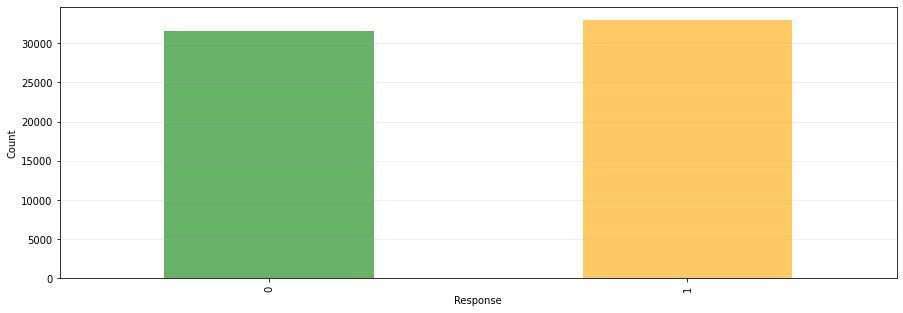

In [23]:
plt.figure(figsize=(15, 5))
df.groupby('Response')['Annual_Premium'] \
    .median() \
    .plot.bar(color=['g','orange'], alpha=0.6)
plt.grid(axis='y', alpha=0.25)
plt.ylabel('Count')
plt.show()

Karena sebelumnya kita tahu bahwa kolom `Annual Premium` ini memiliki distribusi yang skew dikarenakan outlier, maka disini tidak menggunakan nilai `Mean`, karena nilai `Mean` tidak robust terhadap keberadaan outliers. Tetapi dengan memakai nilai `Median` atau nilai tengah pun tidak terlalu jauh perbedaan dari keduanya.

### Response by Policy Sales Channel

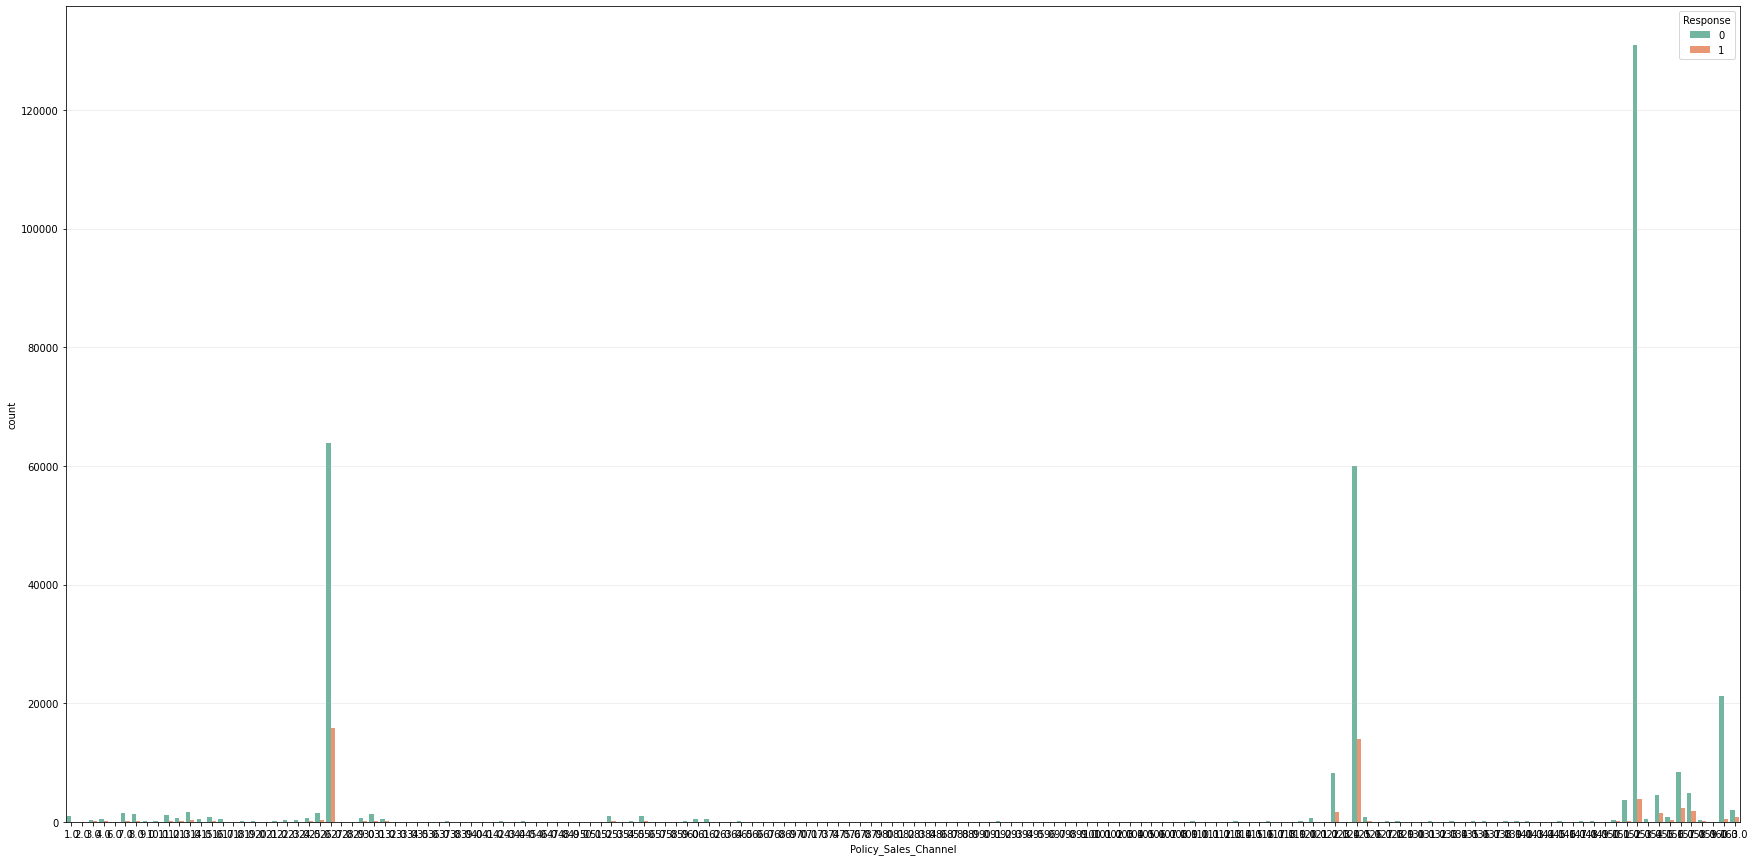

In [24]:
plt.figure(figsize=(30,15))
sns.countplot(x='Policy_Sales_Channel', hue='Response', data=df, palette=sns.color_palette('Set2'))
plt.grid(axis='y', alpha=0.25)
plt.show()

Seperti yang kita ketahui sebelumnya, meskipun kolom `Policy Sales Channel` adalah sebuah kolom numerik, namun angka yang terdapat pada kolom tersebut hanya sebagai kode unik atau label bagaimana perusahaan menghubungi/menjangkau pelanggan, bukan sebuah nilai angka yang bisa dijumlahkan atau dihitung. Dan juga tidak terdapat keterangan yang jelas mengenai keterangan dari setiap angkanya tersebut.

### Response by Vintage

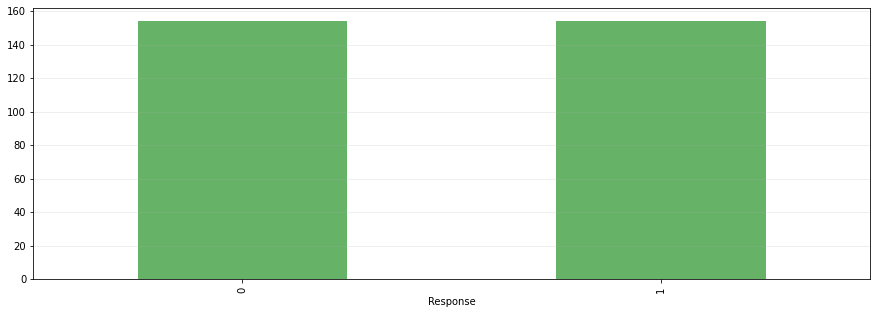

In [25]:
plt.figure(figsize=(15, 5))
df.groupby('Response')['Vintage'].mean().plot.bar(color='g', alpha=0.6)
plt.grid(axis='y', alpha=0.25)
plt.show()

Karena kolom `Vintage` adalah kolom yang berisi informasi mengenai lama pelanggan berlangganan asuransi dalam bentuk jumlah hari, rata-rata dari pelanggan yang tertarik maupun yang tidak cenderung hampir sama, tidak terdapat perbedaan yang signifikan.

### Correlation heatmap

In [26]:
df.corr()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,1.000000,0.001561,-0.000564,-0.000572,0.002457,0.003027,-0.002837,-0.000630,-0.001368
Age,0.001561,1.000000,-0.079782,0.042574,-0.254682,0.067507,-0.577826,-0.001264,0.111147
Driving_License,-0.000564,-0.079782,1.000000,-0.001081,0.014969,-0.011906,0.043731,-0.000848,0.010155
Region_Code,-0.000572,0.042574,-0.001081,1.000000,-0.024659,-0.010588,-0.042420,-0.002750,0.010570
Previously_Insured,0.002457,-0.254682,0.014969,-0.024659,1.000000,0.004269,0.219381,0.002537,-0.341170
Annual_Premium,0.003027,0.067507,-0.011906,-0.010588,0.004269,1.000000,-0.113247,-0.000608,0.022575
Policy_Sales_Channel,-0.002837,-0.577826,0.043731,-0.042420,0.219381,-0.113247,1.000000,0.000002,-0.139042
Vintage,-0.000630,-0.001264,-0.000848,-0.002750,0.002537,-0.000608,0.000002,1.000000,-0.001050
Response,-0.001368,0.111147,0.010155,0.010570,-0.341170,0.022575,-0.139042,-0.001050,1.000000


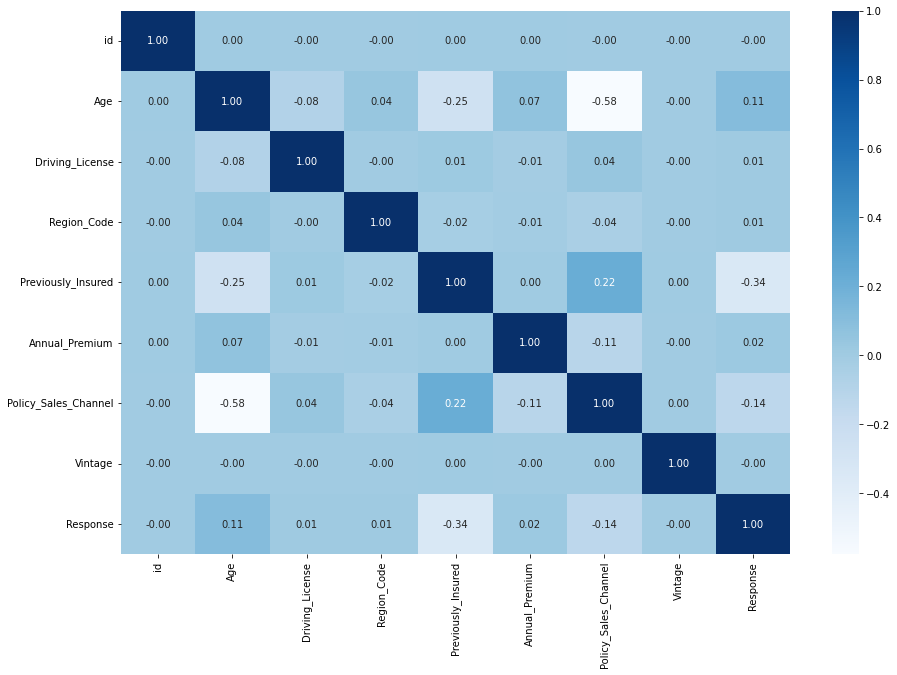

In [27]:
# correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.savefig('images/corr_heatmap.png')
plt.show()

Dari *correlation heatmap* di atas dapat dilihat bahwa:
* Kolom target kita `Response` berkorelasi cukup kuat dengan `Previously Insured` namun korelasinya negatif. 
* Ia memiliki korelasi positif lemah dengan `Age` dan korelasi negatif lemah dengan `Policy Sales Channel` (decent potential feature)
* Sedangkan korelasi `Response` dengan `Driving License` dan `Region Code` sangat lemah ~0, ini menandakan bisa jadi mereka bukan fitur yang potensial
* Kolom `Age` memiliki korelasi negatif yang cukup kuat dengan `Policy Sales Channel`, namun korelasi ini tidak cukup kuat untuk dikatakan redundant.
* Kolom `Vintage` tidak memiliki korelasi sama sekali dengan kolom manapun, menandakan kolom ini tidak penting dan bisa dibuang saja.

## EDA Conclusion

Beberapa hal yang kita temukan dari EDA dataset ini adalah:
* Data terlihat valid dan tidak ada kecacatan yang major/signifikan
* Tipe dan nilai data pada setiap kolom terlihat normal
* Tidak terdapat null values atau nilai yang kosong pada setiap kolom
* Distribusi kolom *target* yaitu `Response` terlihat imbalance. Bila diperlukan, kita akan melakukan teknik oversampling atau undersampling pada kolom tersebut. 
* Pada kolom `Annual Premium` terdapat outliers, maka harus dilakukan handling pada tahap Data Processing.
* Beberapa *feature* memiliki korelasi yang jelas dengan *target*, mereka akan dipakai
* Kolom `Vintage` terlihat sama sekali tidak berkorelasi, baik dengan kolom *target* maupun dengan kolom yang lain, maka sebaiknya diabaikan

# Data Processing

## Train Test Split Dataset

Sebelum melakukan `Data Processing` pada dataset, kita harus membagi dataset menjadi Training data dan Test data supaya tidak terjadi kebocoran data dan membuat data pada "Test Data" tetap organik menggambarkan keadaan data yang sebenarnya di dunia nyata.

In [28]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
print('Jumlah baris pada Data Training : ', len(train_data))
print('Jumlah baris pada Data Testing : ', len(test_data))

Jumlah baris pada Data Training :  342998
Jumlah baris pada Data Testing :  38111


## Drop kolom `id`

Karena kolom `id` adalah sebuah angka unik untuk identitas setiap baris pada data dan tidak berpengaruh sama sekali terhadap model, maka di buang saja.

In [29]:
train_data = train_data.drop('id', axis=1)
train_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
273483,Male,59,1,28.0,0,1-2 Year,Yes,21261.0,26.0,144,0
371246,Female,42,1,1.0,0,1-2 Year,Yes,2630.0,124.0,211,0
90689,Male,23,1,18.0,1,< 1 Year,No,29869.0,152.0,80,0
94809,Female,25,1,47.0,0,< 1 Year,Yes,42822.0,152.0,199,0
50505,Male,55,1,26.0,1,1-2 Year,No,33225.0,22.0,230,0


### Drop kolom `id` pada Test data

In [30]:
test_data = test_data.drop('id', axis=1)
test_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
200222,Female,21,1,3.0,1,< 1 Year,No,20408.0,160.0,72,0
49766,Male,55,1,15.0,0,1-2 Year,Yes,37498.0,26.0,102,0
172201,Female,41,1,3.0,0,1-2 Year,Yes,2630.0,26.0,90,0
160713,Female,26,1,11.0,0,< 1 Year,No,2630.0,151.0,268,0
53272,Male,51,1,40.0,0,1-2 Year,Yes,34006.0,124.0,265,0


## Drop duplicated data

Pada proses EDA, tidak terdapat duplikat data dikarenakan setiap baris masih unik satu sama lain berkat kolom `id`. Setelah kolom `id` di drop, maka akan dicek kembali. 

In [31]:
train_data.duplicated().sum()

212

Ternyata, terdapat 168 baris data yang duplikat atau sama pada data training. Maka akan dilakukan dropping.

In [32]:
print('Jumlah baris duplikat sebelum didrop : ', train_data.duplicated().sum())
train_data = train_data.drop_duplicates()
print('Jumlah baris duplikat setelah didrop : ', train_data.duplicated().sum())

Jumlah baris duplikat sebelum didrop :  212
Jumlah baris duplikat setelah didrop :  0


## Handling Outliers

Saya akan melakukan handling outliers pada kolom `Annual Premium` yang sebelumnya sudah dicek terdapat keberadaan outlier.

In [33]:
# Create function that can dropping rows with outliers value
def removing_outlier(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low_limit = q1 - 1.5*iqr
    hig_limit = q3 + 1.5*iqr
    no_outliers = df[(df[col]>low_limit)&(df[col]<hig_limit)]
    return no_outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x20de97cdd20>,
 'caps': [<matplotlib.lines.Line2D at 0x20de97cfdf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20de97cf970>],
 'medians': [<matplotlib.lines.Line2D at 0x20de9b972e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x20de9b96fb0>],
 'means': []}

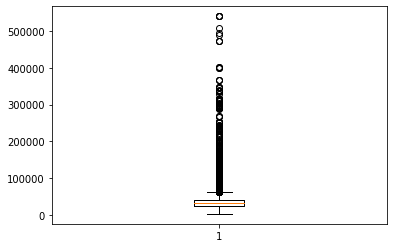

In [34]:
# Check the distribution of annual premium using boxplot before handling outliers
plt.boxplot(train_data['Annual_Premium'])

In [35]:
print('Jumlah baris sebelum drop outliers : ', len(train_data))
train_data = removing_outlier(train_data,"Annual_Premium")
print('Jumlah baris setelah drop outliers : ', len(train_data))

Jumlah baris sebelum drop outliers :  342786
Jumlah baris setelah drop outliers :  333500


{'whiskers': [<matplotlib.lines.Line2D at 0x20de96c97b0>,
 'caps': [<matplotlib.lines.Line2D at 0x20de96cbdf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20de96cad70>],
 'medians': [<matplotlib.lines.Line2D at 0x20de96cb430>],
 'fliers': [<matplotlib.lines.Line2D at 0x20de96c9360>],
 'means': []}

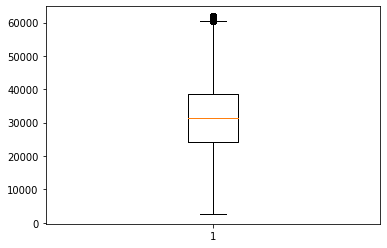

In [36]:
# Check the distribution of annual premium using boxplot after handling outliers
plt.boxplot(train_data['Annual_Premium'])

## Feature Encoding

### Label Encoding

Pada kolom kategorikal, saya akan melakukan encoding agar nilai pada kolom tersebut menjadi sebuah angka. Pada kolom `Vehicle Age` akan dilakukan Label Encoding karena pada kolom tersebut berisi nilai Ordinal.

In [37]:
map_vehicle_age = {'< 1 Year':1,
                   '1-2 Year':2,
                   '> 2 Years':3}
train_data['Vehicle_Age'] = train_data['Vehicle_Age'].map(map_vehicle_age)

In [38]:
train_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
273483,Male,59,1,28.0,0,2,Yes,21261.0,26.0,144,0
371246,Female,42,1,1.0,0,2,Yes,2630.0,124.0,211,0
90689,Male,23,1,18.0,1,1,No,29869.0,152.0,80,0
94809,Female,25,1,47.0,0,1,Yes,42822.0,152.0,199,0
50505,Male,55,1,26.0,1,2,No,33225.0,22.0,230,0


Cek keberhasilan Encoding pada kolom `Vehicle Age`

In [39]:
train_data['Vehicle_Age'].value_counts()

2    174659
1    145254
3     13587
Name: Vehicle_Age, dtype: int64

### One Hot Encoding

Untuk kolom kategorikal lainnya yaitu `Gender` dan `Vehicle Damage` akan dilakukan One Hot Encoding karena hanya berisi 2 nilai saja dan akan drop salah satu kolom hasil encoding nanti.

In [40]:
for kolom in ['Gender','Vehicle_Damage']:
    onehots = pd.get_dummies(train_data[kolom], prefix=kolom, drop_first=True)
    train_data = train_data.join(onehots)
train_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Damage_Yes
273483,Male,59,1,28.0,0,2,Yes,21261.0,26.0,144,0,1,1
371246,Female,42,1,1.0,0,2,Yes,2630.0,124.0,211,0,0,1
90689,Male,23,1,18.0,1,1,No,29869.0,152.0,80,0,1,0
94809,Female,25,1,47.0,0,1,Yes,42822.0,152.0,199,0,0,1
50505,Male,55,1,26.0,1,2,No,33225.0,22.0,230,0,1,0


### Drop kolom dari proses One Hot Encoding

In [41]:
train_data = train_data.drop(columns=['Gender','Vehicle_Damage'], axis=1)
train_data.head()

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Damage_Yes
273483,59,1,28.0,0,2,21261.0,26.0,144,0,1,1
371246,42,1,1.0,0,2,2630.0,124.0,211,0,0,1
90689,23,1,18.0,1,1,29869.0,152.0,80,0,1,0
94809,25,1,47.0,0,1,42822.0,152.0,199,0,0,1
50505,55,1,26.0,1,2,33225.0,22.0,230,0,1,0


## Feature Encoding - Test Data

In [42]:
test_data['Vehicle_Age'] = test_data['Vehicle_Age'].map(map_vehicle_age)
for kolom in ['Gender','Vehicle_Damage']:
    onehots = pd.get_dummies(test_data[kolom], prefix=kolom, drop_first=True)
    test_data = test_data.join(onehots)
test_data = test_data.drop(columns=['Gender','Vehicle_Damage'], axis=1)
test_data.head()

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Damage_Yes
200222,21,1,3.0,1,1,20408.0,160.0,72,0,0,0
49766,55,1,15.0,0,2,37498.0,26.0,102,0,1,1
172201,41,1,3.0,0,2,2630.0,26.0,90,0,0,1
160713,26,1,11.0,0,1,2630.0,151.0,268,0,0,0
53272,51,1,40.0,0,2,34006.0,124.0,265,0,1,1


## Save clean data to csv file

In [43]:
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')